In [1]:
# Making Necessary Imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.stats import norm, invgamma
from math import sqrt, log, exp, pi

(array([0.06071575, 0.0242863 , 0.        , 0.        , 0.        ,
        0.        , 0.0242863 , 0.        , 0.        , 0.0728589 ,
        0.25500613, 0.10928834, 0.08500204, 0.12143149, 0.10928834,
        0.06071575, 0.01214315, 0.0242863 , 0.        , 0.        ,
        0.        , 0.        , 0.01214315, 0.01214315, 0.01214315]),
 array([ 9.172  , 10.17628, 11.18056, 12.18484, 13.18912, 14.1934 ,
        15.19768, 16.20196, 17.20624, 18.21052, 19.2148 , 20.21908,
        21.22336, 22.22764, 23.23192, 24.2362 , 25.24048, 26.24476,
        27.24904, 28.25332, 29.2576 , 30.26188, 31.26616, 32.27044,
        33.27472, 34.279  ]),
 <BarContainer object of 25 artists>)

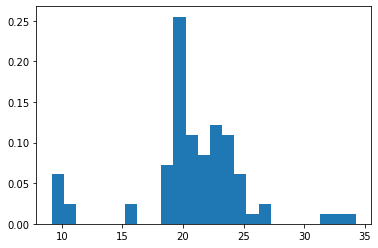

In [2]:
# Importing the dataset

galaxies = pd.read_csv("galaxies.csv")
galaxies['x'] = galaxies['x']/1000
velocities = galaxies['x']
plt.hist(velocities, bins = 25, density=True)

In [3]:
data = velocities

In [4]:
# Function to calculate pi_i_k
def calculate_pi_ik(data, pi_k, mu_k, sigma_k, K):
    pi_i_k = np.zeros((len(data), K))
    for i in range(len(data)):
        for k in range(K):
            numerator = pi_k[k]*norm.pdf(data[i], mu_k[k], sigma_k[k])
            denominator = 0
            for j in range(K):
                denominator = denominator + pi_k[j]*norm.pdf(data[i], mu_k[j], sigma_k[j])
            pi_i_k[i][k] = numerator/denominator
    return pi_i_k

In [5]:
#Calculate the zs (label values)
def calculate_z(data, pi_k, mu_k, sigma_k, K):
    zi = []
    pi_i_k = calculate_pi_ik(data, pi_k, mu_k, sigma_k, K)
    for i in range(len(data)):
        zi.append(np.random.multinomial(1, pi_i_k[i:][0]))
    return zi

In [6]:
def calculate_z(data, pi_k, mu_k, sigma_k, K):
    zi = []
    zis = np.zeros(K)
    for i in range(K):
        pos = np.random.choice(list(range(K)))
        zis[pos] = 1
        zi.append(zis)
    return zi

In [7]:
K = 3
pi_old = [np.random.uniform(0, 1) for _ in range(K)]
pi_old = np.asarray(pi_old)
pi_old = pi_old/np.sum(pi_old)
pi_old = pi_old.tolist()

mu_old = [np.random.uniform(1, 50) for _ in range(K)]
sigma_old = [np.random.uniform(1, 10) for _ in range(K)]

In [8]:
pi_i_k = calculate_pi_ik(velocities, pi_old, mu_old, sigma_old, K)
z = calculate_z(velocities, pi_old, mu_old, sigma_old, K)

In [9]:
def calculate_y_bar_k(data, z, K):
    y_bar_k = []
    for k in range(K):
        sum = 0
        for i in range(len(z)):
            if(z[i][k] == 1):
                sum += data[i]
        y_bar_k.append(sum)
    return y_bar_k

In [10]:
def calculate_n_k(z, K):
    n_k = []
    for k in range(K):
        sum = 0
        for i in range(len(z)):
            if(z[i][k] == 1):
                sum += 1
        n_k.append(sum)
    return n_k

In [11]:
n_k = calculate_n_k(z, K)

In [12]:
n_k

[0, 3, 3]

In [13]:
def calculate_sigma_k_n(sigma_0, n_k, sigma_k, K):
    sigma_k_n = []
    for k in range(K):
        sum = 1/((1/sigma_0[k]**2) + (n_k[k]/sigma_k[k]**2))
        sigma_k_n.append(sum)
    return sigma_k_n

In [14]:
sigma_k_n = calculate_sigma_k_n(sigma_old, n_k, sigma_old, K)

In [15]:
def calculate_mu_k_n(sigma_k_n, sigma_k, sigma_0, mu_0, z, data, K):
    mu_k_n = []
    y_bar_k = calculate_y_bar_k(data, z, K)
    n_k = calculate_n_k(z, K)
    for k in range(K):
        prod = (sigma_k_n[k])*((mu_0[k]/sigma_0[k]**2) + n_k[k]*y_bar_k[k]/sigma_k[k]**2)
        mu_k_n.append(prod)
    return mu_k_n

In [16]:
mu_k_n = calculate_mu_k_n(sigma_k_n, sigma_old, sigma_old, mu_old, z, velocities, K)

In [17]:
def sample_mu_k(data, pi_k, mu_k, sigma_k, K, sigma_0, mu_0):
    sigma_k_n = calculate_sigma_k_n(sigma_0, n_k, sigma_k, K)
    z = calculate_z(data, pi_k, mu_k, sigma_k, K)
    mu_k_n = calculate_mu_k_n(sigma_k_n, sigma_k, sigma_0, mu_0, z, data, K)
    mu_k_new = []
    for k in range(K):
        mu_k_new.append(norm.pdf(mu_k[k], mu_k_n[k], sigma_k_n[k]))
    return mu_k_new

In [18]:
mu_k = sample_mu_k(velocities, pi_old, mu_old, sigma_old, K, sigma_old, mu_old)

In [19]:
def calculate_a_k_n(a_0, data, pi_k, mu_k, sigma_k, K):
    z = calculate_z(data, pi_k, mu_k, sigma_k, K)
    n_k = calculate_n_k(z, K)
    a_k_n = []
    for k in range(K):
        a_k_n.append(a_0[k] + n_k[k]/2)
    return a_k_n

In [20]:
def calculate_b_k_n(b_0, data, pi_k, mu_k, sigma_k, K):
    z = calculate_z(data, pi_k, mu_k, sigma_k, K)
    n_k = calculate_n_k(z, K)
    y_bar_k = calculate_y_bar_k(data, z, K)
    b_k_n = []
    for k in range(K):
        b_k_n.append(b_0[k] + (((n_k[k] - 1)*sigma_k[k])/2) + ((n_k[k]*(y_bar_k[k] - mu_k[k])**2)/2))
    return b_k_n

In [21]:
def sample_sigma_k(a_0, b_0, data, pi_k, mu_k, sigma_k,K):
    sigma_k_new = []
    a_k_n = calculate_a_k_n(a_0, data, pi_k, mu_k, sigma_k, K)
    b_k_n = calculate_b_k_n(b_0, data, pi_k, mu_k, sigma_k, K)
    for k in range(K):
        sigma_k_new.append(invgamma.pdf(sigma_k[k], a_k_n[k], b_k_n[k]))
    return sigma_k_new

In [22]:
a_0 = [np.random.uniform(1,10) for _ in range(K)]
b_0 = [np.random.uniform(1,10) for _ in range(K)]

In [23]:
sample_sigma_k(a_0, b_0, data, pi_old, mu_old, sigma_old, K)

[0.0, 2.262309039411685e-85, 0.0]

In [24]:
def sample_pi_k(data, pi_k, mu_k, sigma_k, K):
    pi_k_new = []
    pi_i_k = calculate_pi_ik(data, pi_k, mu_k, sigma_k, K)
    for k in range(K):
        numerator = 0
        for i in range(len(data)):
            numerator = numerator + pi_i_k[i][k]
        denominator = 0
        for j in range(K):
            for l in range(len(data)):
                denominator = denominator + pi_i_k[l][k]
        pi_k_new.append(numerator/denominator)
    return pi_k_new
    

In [25]:
def gibbs_sampler(iterations, data, K):
    pi_old = [np.random.uniform(0, 1) for _ in range(K)]
    pi_old = np.asarray(pi_old)
    pi_old = pi_old/np.sum(pi_old)
    pi_old = pi_old.tolist()

    mu_old = [np.random.uniform(1, 50) for _ in range(K)]
    sigma_old = [np.random.uniform(1, 10) for _ in range(K)]
    a_0 = [np.random.uniform(1,10) for _ in range(K)]
    b_0 = [np.random.uniform(1,10) for _ in range(K)]
    
    mu_new = sample_mu_k(data, pi_old, mu_old, sigma_old, K, sigma_old, mu_old)
    sigma_new = sample_sigma_k(a_0, b_0, data, pi_old, mu_old, sigma_old,K)
    pi_new = sample_pi_k(data, pi_old, mu_old, sigma_old, K)

    sampled_mu_k = [mu_new]
    sampled_sigma_k = [sigma_new]
    sampled_pi_k = [pi_new]
    for i in range(iterations):
        pi_temp = sample_pi_k(data, pi_new, mu_new, sigma_new, K)
        mu_temp = sample_mu_k(data, pi_temp, mu_new, sigma_new, K, sigma_old, mu_old)
        sigma_temp = sample_sigma_k(a_0, b_0, data, pi_temp, pi_temp, sigma_new,K)
        sampled_pi_k.append(pi_temp)
        sampled_mu_k.append(mu_temp)
        sampled_sigma_k.append(sigma_temp)
        pi_new = pi_temp
        sigma_new = sigma_temp
        mu_new = mu_temp
    return pi_new, mu_new, sigma_new 

In [26]:
pi_new, mu_new, sigma_new = gibbs_sampler(100, velocities, 3)

c:\Users\rahul\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:1870: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\rahul\AppData\Local\Temp/ipykernel_19308/3876186614.py:4: RuntimeWarning: invalid value encountered in double_scalars
  sum = 1/((1/sigma_0[k]**2) + (n_k[k]/sigma_k[k]**2))
C:\Users\rahul\AppData\Local\Temp/ipykernel_19308/3876186614.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  sum = 1/((1/sigma_0[k]**2) + (n_k[k]/sigma_k[k]**2))
C:\Users\rahul\AppData\Local\Temp/ipykernel_19308/2592960678.py:6: RuntimeWarning: invalid value encountered in double_scalars
  prod = (sigma_k_n[k])*((mu_0[k]/sigma_0[k]**2) + n_k[k]*y_bar_k[k]/sigma_k[k]**2)
C:\Users\rahul\AppData\Local\Temp/ipykernel_19308/2592960678.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  prod = (sigma_k_n[k])*((mu_0[k]/sigma_0[k]**2) + n_k[k]*y_bar_k[k]/sigma

In [27]:
sigma_new

[nan, nan, nan]